# Real-time Epidemic Modelling of SARS-CoV-2 from Wastewater Data
## Data Wrangling

In [2]:
# Please install openpyxl and odfpy from pip or anaconda in order for pandas to import the ods and xlsx data files
import sys
# !{sys.executable} -m pip install openpyxl
# !{sys.executable} -m pip install odfpy

# Import libraries and set plot styles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warning for chained assignment
pd.options.mode.chained_assignment = None  # default='warn'

# Show plots inline
%matplotlib inline

# Set plot style
plt.style.use('ggplot')
sns.set_style("darkgrid")

In [8]:
# Read in data
df = pd.read_csv('data/agg_data_inner_11_cis_mar22.csv',
                 parse_dates=['date'],
                 dayfirst=True)
df1 = pd.read_excel('data/Region Mapping.xlsx')
df2 = pd.read_excel('data/R_and_growth_rate_time_series_for_publication_v1.0.ods',
                    sheet_name=2,
                    engine='odf',
                    header=[7,8], #Two rows of header
                    na_values='.'
                    )
real_cases = pd.read_csv("data/newcasesbyspecimendate.csv")
region_weights = pd.read_excel("data/Region Intersection.xlsx",
                                sheet_name=0)
region_weights = region_weights.iloc[:, [3,12,19]] # select region names (administrative and NHS) and area

# Check for missing values
# df.isnull().sum()

In [971]:
# Select header titles and data range
df1.columns = df1.iloc[2]
region_map = df1.iloc[3:, :]
r_val = df2.iloc[:, 1:]

# Merge 2 header rows
r_val.columns = ['_'.join(header).upper() for header in r_val.columns]
r_val.drop(['UK_UPPER BOUND', 'UK_LOWER BOUND'], axis=1)

# Remove missing values
region_map.dropna()
r_val = r_val.dropna()

# Rename specific columns for joining
df.rename(columns={'cis20cd': 'CIS20CD'}, inplace=True)
df.rename(columns={'grab_compo_boo': 'compo_frac'}, inplace=True)
region_map.rename(columns={'Geography Code': 'CIS20CD', 'Region': 'region'}, inplace=True)
real_cases.rename(columns={'areaName': 'region'}, inplace=True)
r_val.rename(columns={'DATE_UNNAMED: 1_LEVEL_1': 'date'}, inplace=True)
region_weights.rename(columns={'nhser20nm': 'nhs_region', 'rgn17nm': 'region'}, inplace=True)

# Capitalise first letter of each word of 'region' for table joining later
region_map['region'] = region_map['region'].str.title()
real_cases['region'] = real_cases['region'].str.title()
region_weights = region_weights.applymap(lambda s: s.title() if type(s) == str else s)

In [972]:
# Convert string to date
df['date'] = pd.to_datetime(df['date'])
# tmp = pd.to_datetime(r_val['date'],
#                      format = '%Y-%m-%d %H:%M:%S',
#                      errors='coerce')
# r_val.date = r_val.date.where(tmp.isna(), tmp.dt.date)
r_val['date'] = pd.to_datetime(r_val['date'])

real_cases['date'] = pd.to_datetime(real_cases['date'])

# Subset incidence data within study period
real_cases = real_cases[real_cases['date'].between('2020-09-04', '2021-02-10')]
real_cases = real_cases.set_index('date')
real_cases = real_cases.sort_index()

In [973]:
# 7-day moving average of cases
cases_7d_mean = pd.DataFrame(real_cases.groupby("region").rolling('7D').newCasesBySpecimenDate.mean())
cases_7d_mean = cases_7d_mean.rename(columns={"newCasesBySpecimenDate":"cases_7d_avg"})

combined_cases = real_cases.copy()
combined_cases = combined_cases.merge(cases_7d_mean, on=['region', 'date'])

<Figure size 432x288 with 0 Axes>

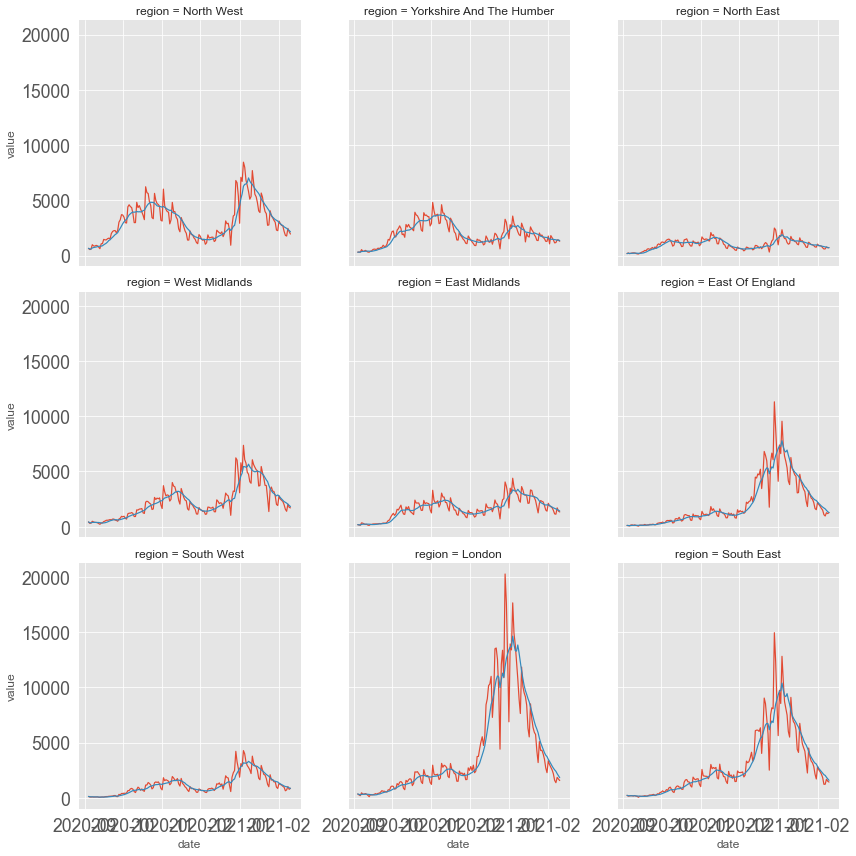

In [974]:
# Check rolling average by plotting regional numbers
l = combined_cases.copy().reset_index()
l = l.melt(id_vars=['date', 'region', 'areaCode', 'areaType'])

plt.figure()
g = sns.FacetGrid(l, col="region", col_wrap=3, height=4,
                  col_order=['North West', 'Yorkshire And The Humber', 'North East',
                             'West Midlands', 'East Midlands', 'East Of England',
                             'South West','London' , 'South East'],
                  hue='variable')
g.map(sns.lineplot, "date", "value")

### Average R values for each NHS region

In [975]:
# r_val['UK_AVERAGE'] = r_val[['UK_LOWER BOUND', 'UK_UPPER BOUND']].mean(axis=1)
r_val['ENGLAND_AVERAGE'] = r_val[['ENGLAND_LOWER BOUND', 'ENGLAND_UPPER BOUND']].mean(axis=1)
r_val['EAST OF ENGLAND_AVERAGE'] = r_val[['EAST OF ENGLAND_LOWER BOUND', 'EAST OF ENGLAND_UPPER BOUND']].mean(axis=1)
r_val['LONDON_AVERAGE'] = r_val[['LONDON_LOWER BOUND', 'LONDON_UPPER BOUND']].mean(axis=1)
r_val['MIDLANDS_AVERAGE'] = r_val[['MIDLANDS_LOWER BOUND', 'MIDLANDS_UPPER BOUND']].mean(axis=1)
r_val['NORTH EAST AND YORKSHIRE_AVERAGE'] = r_val[['NORTH EAST AND YORKSHIRE_LOWER BOUND', 'NORTH EAST AND YORKSHIRE_UPPER BOUND']].mean(axis=1)
r_val['NORTH WEST_AVERAGE'] = r_val[['NORTH WEST_LOWER BOUND', 'NORTH WEST_UPPER BOUND']].mean(axis=1)
r_val['SOUTH EAST_AVERAGE'] = r_val[['SOUTH EAST_LOWER BOUND', 'SOUTH EAST_UPPER BOUND']].mean(axis=1)
r_val['SOUTH WEST_AVERAGE'] = r_val[['SOUTH WEST_LOWER BOUND', 'SOUTH WEST_UPPER BOUND']].mean(axis=1)

# Export averages of R
melt_r_a = pd.melt(r_val[['date', 'ENGLAND_AVERAGE', #'ENGLAND_LOWER BOUND', 'ENGLAND_UPPER BOUND',
                        'EAST OF ENGLAND_AVERAGE', #'EAST OF ENGLAND_LOWER BOUND', 'EAST OF ENGLAND_UPPER BOUND',
                        'LONDON_AVERAGE', #'LONDON_LOWER BOUND', 'LONDON_UPPER BOUND',
                        'MIDLANDS_AVERAGE', #'MIDLANDS_LOWER BOUND', 'MIDLANDS_UPPER BOUND',
                        'NORTH EAST AND YORKSHIRE_AVERAGE', #'NORTH EAST AND YORKSHIRE_LOWER BOUND',
                        #'NORTH EAST AND YORKSHIRE_UPPER BOUND',
                        'NORTH WEST_AVERAGE', #'NORTH WEST_LOWER BOUND', 'NORTH WEST_UPPER BOUND',
                        'SOUTH EAST_AVERAGE', #'SOUTH EAST_LOWER BOUND', 'SOUTH EAST_UPPER BOUND',
                        'SOUTH WEST_AVERAGE', #'SOUTH WEST_LOWER BOUND', 'SOUTH WEST_UPPER BOUND'
                        ]],
                 id_vars=['date'])

melt_r_u = pd.melt(r_val[['date', 'ENGLAND_UPPER BOUND',
                          'EAST OF ENGLAND_UPPER BOUND',
                          'LONDON_UPPER BOUND',
                          'MIDLANDS_UPPER BOUND',
                          'NORTH EAST AND YORKSHIRE_UPPER BOUND',
                          'NORTH WEST_UPPER BOUND',
                          'SOUTH EAST_UPPER BOUND',
                          'SOUTH WEST_UPPER BOUND'
                          ]],
                   id_vars=['date'])

melt_r_l = pd.melt(r_val[['date', 'ENGLAND_LOWER BOUND',
                          'EAST OF ENGLAND_LOWER BOUND',
                          'LONDON_LOWER BOUND',
                          'MIDLANDS_LOWER BOUND',
                          'NORTH EAST AND YORKSHIRE_LOWER BOUND',
                          'NORTH WEST_LOWER BOUND',
                          'SOUTH EAST_LOWER BOUND',
                          'SOUTH WEST_LOWER BOUND'
                          ]],
                   id_vars=['date'])

# Create column for join
melt_r_a['nhs_region'] = melt_r_a['variable'].map(lambda x: str(x)[:-8].title())
melt_r_u['nhs_region'] = melt_r_u['variable'].map(lambda x: str(x)[:-12].title())
melt_r_l['nhs_region'] = melt_r_l['variable'].map(lambda x: str(x)[:-12].title())

r_cleaned = pd.merge(pd.merge(melt_r_a, melt_r_l, on=['date', 'nhs_region'], how='left'),
                     melt_r_u, on=['date', 'nhs_region'], how='outer')

# Rename and drop columns
r_cleaned.rename(columns={'value_x': 'r_avg', 'value_y': 'r_lower', 'value':'r_upper'}, inplace=True)
r_cleaned = r_cleaned[['date', 'nhs_region', 'r_lower', 'r_avg', 'r_upper']]
r_cleaned.to_csv('data/r_before_weights.csv')

### Linkage and weighted average

In [976]:
# Match region to codes in wastewater data
df3 = pd.merge(df, region_map[['CIS20CD', 'region']], on='CIS20CD', how='left')
df3.to_csv("data/agg_data_with_region.csv")

# Export a list of CIS sub-regions
pd.DataFrame(df3.CIS20CD.unique()).to_csv("unique_CIS20CD.csv")

# Weighted average
grouped = df3.groupby(['region', 'date'])

def wavg(group):
    d = group['sars_cov2_gc_l_mean']
    ss = group['suspended_solids_mg_l']
    a = group['ammonia_mg_l']
    o = group['ophosph_mg_l']
    ph = group['sample_ph_pre_ansis']
    ctrl = group['control_gc_l_mean']
    rvc = group['reac_vol_control']
    ra = group['raw_ansis_sars_repc_std']
    cf = group['compo_frac']
    sblod = group['sars_below_lod']
    sbloq = group['sars_below_loq']
    rd = group['reception_delay']
    w = group['catch_cis_population']
    return (d * w).sum()/(w.sum()), (ss * w).sum()/w.sum(), (a * w).sum()/w.sum(), (o * w).sum()/w.sum(), (ph * w).sum()/w.sum(), (ctrl * w).sum()/w.sum(), (rvc * w).sum()/w.sum(), (ra * w).sum()/w.sum(), (cf * w).sum()/w.sum(), (sblod* w).sum()/w.sum(), (sbloq * w).sum()/w.sum(), (rd * w).sum()/w.sum(), w.sum()

df4= grouped.apply(wavg)
df4 = df4.reset_index()

# rename weighted average column
df4.rename(columns={0: 'temp'}, inplace=True)

# assign function output into separate columns
df4['weighted_avg_sars_cov2'], df4['suspended_solids_weighted'], df4['ammonia_weighted'], df4['ophosph_weighted'], df4['sample_ph_weighted'], df4['control_weighted'], df4['reac_vol_control_weighted'], df4['raw_ansis_sars_repc_std_weighted'], df4['compo_frac_weighted'], df4['sars_below_lod_weighted'], df4['sars_below_loq_weighted'], df4['reception_delay_weighted'], df4['regional_popn'], = zip(*df4.temp)

# Drop combined column
df4 = df4.drop(columns='temp')

In [1009]:
# Number of sub-regions in each region
# df3.groupby('region').nunique('CIS20CD')

,Unnamed: 0,CIS20CD,date,sars_cov2_gc_l_mean,suspended_solids_mg_l,ammonia_mg_l,ophosph_mg_l,sample_ph_pre_ansis,control_gc_l_mean,reac_vol_control,...,sars_below_lod,sars_below_loq,reception_delay,catchment_population_ons_mid_2019,catchment_area,catch_in_cis_prop,catch_cis_population,median_prob,ll,ul
region,,,,,,,,,,,,,,,,,,,,,
East Midlands,588,7,88,333,89,85,80,7,5,1,...,2,2,233,4,4,7,7,588,588,588
East Of England,704,8,91,570,317,313,335,17,14,1,...,22,12,513,13,13,8,8,704,704,704
London,2398,27,91,1590,1277,1135,1213,55,28,1,...,49,30,1453,27,29,27,27,2398,2398,2398
North East,173,2,87,150,49,54,58,3,2,1,...,2,1,142,2,2,2,2,173,173,173
North West,889,10,110,171,260,240,258,24,10,1,...,5,1,429,12,10,10,10,889,889,889
South East,722,8,107,568,389,424,434,21,18,1,...,25,6,532,15,16,8,8,722,722,722
South West,502,6,90,284,104,109,98,8,7,1,...,2,1,253,5,5,6,6,502,502,502
West Midlands,743,9,89,303,203,205,215,12,8,1,...,9,7,263,9,9,9,9,743,743,743
Yorkshire And The Humber,519,6,89,273,242,214,242,10,8,1,...,5,1,322,6,8,6,6,519,519,519


In [977]:
# Join average R estimates (7 NHS regions) and weights of 9 administrative regions
df5 = pd.merge(region_weights, r_cleaned, on='nhs_region', how='left')

In [978]:
# Weighted average of R values
grouped2 = df5.dropna().groupby(['region', 'date'])

def wavg2(group):
    rl = group['r_lower']
    ra = group['r_avg']
    ru = group['r_upper']
    w = group['area']
    return (rl * w).sum() / w.sum(), (ra * w).sum() / w.sum(), (ru* w).sum() / w.sum()

weighted_r = grouped2.apply(wavg2)
weighted_r = weighted_r.reset_index()

# rename weighted average column
weighted_r.rename(columns={0: 'temp'}, inplace=True)

# assign function output into separate columns
weighted_r['avg_r_lower'], weighted_r['avg_r_avg'], weighted_r['avg_r_upper'] = zip(*weighted_r.temp)

# Drop combined column
weighted_r = weighted_r.drop(columns='temp')

# Check number of regions
weighted_r.region.nunique()

9

In [979]:
# Match with R values
model_dataset = pd.merge(df4, weighted_r, on=['date', 'region'], how='left')

In [980]:
# # Dimension of dataframe
# model_dataset.shape
#
# # Number of unique sites
# model_dataset.region.nunique()
#
# # Date range
# print('Study period from', model_dataset.date.min(), 'to', model_dataset.date.max())

#### Subsets

In [981]:
# # Create a class object holding all subsets (not sure how to perform interpolation over it, tbc)
# class model_dataset_names:
#     pass
#
# subset_model_dataset = model_dataset_names()
#
# subsets = model_dataset['region'].unique()
#
# for subset in subsets:
#     setattr(subset_model_dataset, f"{subset}", model_dataset[model_dataset['region']==subset].reset_index(drop=True))
#
# for subset in subsets:
#     print(getattr(subset_model_dataset, f"{subset}"))

In [982]:
subset_nw = model_dataset.loc[(model_dataset['region'] == 'North West'),:]
subset_yh = model_dataset.loc[(model_dataset['region'] == 'Yorkshire And The Humber'),:]
subset_ne = model_dataset.loc[(model_dataset['region'] == 'North East'),:]
subset_wm = model_dataset.loc[(model_dataset['region'] == 'West Midlands'),:]
subset_em = model_dataset.loc[(model_dataset['region'] == 'East Midlands'),:]
subset_ee = model_dataset.loc[(model_dataset['region'] == 'East Of England'),:]
subset_sw = model_dataset.loc[(model_dataset['region'] == 'South West'),:]
subset_ldn = model_dataset.loc[(model_dataset['region'] == 'London'),:]
subset_se = model_dataset.loc[(model_dataset['region'] == 'South East'),:]

In [983]:
subsets = [subset_nw, subset_yh, subset_ne, subset_wm, subset_em, subset_ee, subset_sw, subset_ldn, subset_se]

#### Perform interpolation into daily data

In [984]:
def interpolation(subset):
    # Set index as date to perform interpolation
    subset.index = subset['date']
    # del subset['date']

    # Linear interpolation
    daily_interpol = subset.resample('D').mean().interpolate('linear')
    # daily_interpol['sars_cov2_gc_l_mean']=daily_interpol['sars_cov2_gc_l_mean'].interpolate()

    # This would remove the first rows without interpolated r values -> to be fixed
    daily_interpol = daily_interpol.dropna().reset_index()

    # log-transformation of selected variables
    daily_interpol['log_weighted_avg'] = np.log10(daily_interpol['weighted_avg_sars_cov2'])
    daily_interpol['log_suspended_solids'] = np.log10(daily_interpol['suspended_solids_weighted'])
    daily_interpol['log_ammonia'] = np.log10(daily_interpol['ammonia_weighted'])
    daily_interpol['log_ophosph'] = np.log10(daily_interpol['ophosph_weighted'])
    return daily_interpol

In [985]:
# Interpolate over all subsets
# Create an empty list of dataframes first
interpolated_subset = [pd.DataFrame() for x in range(9)]

for i in range(0,len(subsets)):
    interpolated_subset[i] = interpolation(subsets[i])

In [986]:
# Add regions name
for i in range(0,len(interpolated_subset)):
    interpolated_subset[i]['region'] = subsets[i]['region'][1]

In [987]:
combined_dataset = pd.concat(interpolated_subset)

#### Create variable - gene copies per day

In [988]:
# Obtain mode of population
popn_mode = combined_dataset.groupby(['region'])['regional_popn'].agg(pd.Series.mode).reset_index()
popn_mode = popn_mode.rename(columns={'regional_popn': 'popn_mode'})

# # Calculate gene copies per day
combined_dataset = combined_dataset.merge(popn_mode,how='left',on='region')
combined_dataset['gc_per_day'] = combined_dataset['weighted_avg_sars_cov2'] * combined_dataset['popn_mode'] * 400

# log-transformation
combined_dataset['log_gc_per_day'] = np.log10(combined_dataset['gc_per_day'])

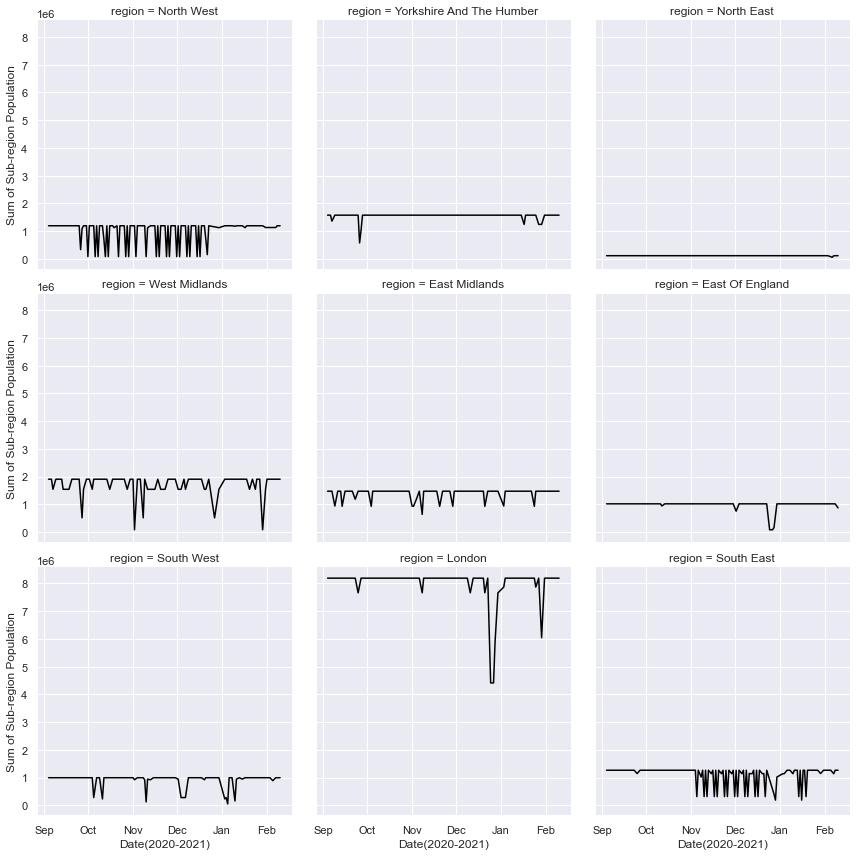

In [1037]:
import matplotlib.dates as mdates

# Regional population changes
g = sns.FacetGrid(combined_dataset, col="region", col_wrap=3, height=4)
g.map(sns.lineplot, "date", "regional_popn", color='black').set_axis_labels("Date(2020-2021)", "Sum of Sub-region Population")

# Fix x-axis dates
g.axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# g.map(sns.lineplot, "date", "popn_mode")

g.savefig('population over time.png')

### Graphs (some repeated in R)

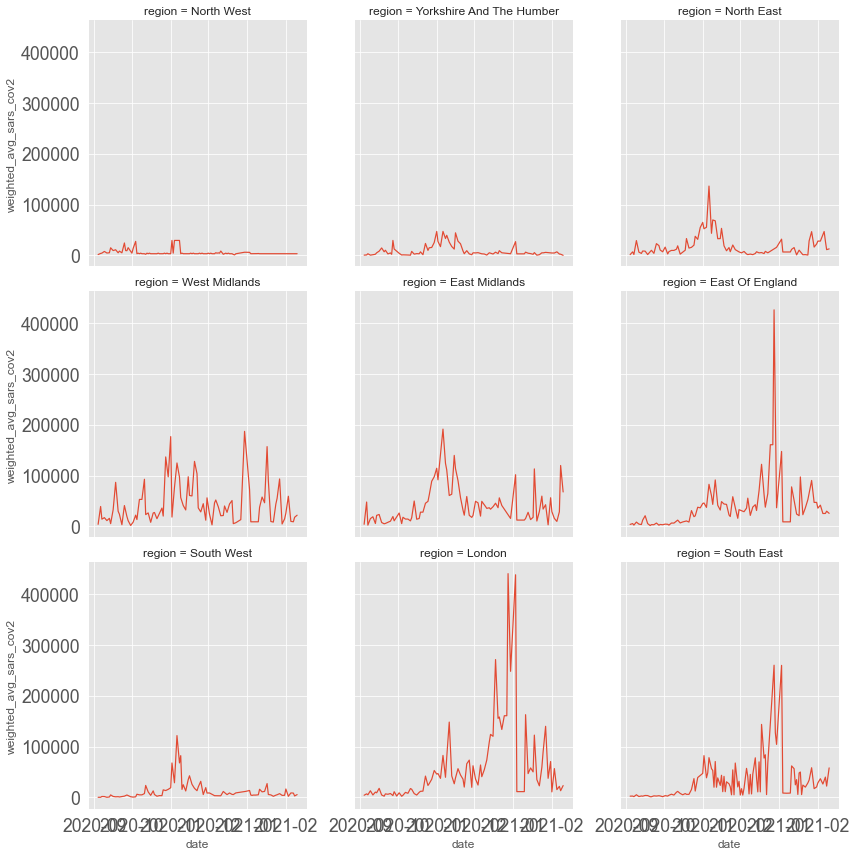

In [990]:
# Raw RNA concentration AFTER Interpolation
g = sns.FacetGrid(combined_dataset, col="region", col_wrap=3, height=4)
g.map(sns.lineplot, "date", "weighted_avg_sars_cov2")

/var/folders/st/76qg2qy17gx68wvlkq_41fkw0000gn/T/ipykernel_66555/1908581449.py:23: FutureWarning: ['CIS20CD', 'region'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  grouptemp = group.groupby('date').agg(fn)
/var/folders/st/76qg2qy17gx68wvlkq_41fkw0000gn/T/ipykernel_66555/1908581449.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groupall = groupall.append(grouptemp)
/var/folders/st/76qg2qy17gx68wvlkq_41fkw0000gn/T/ipykernel_66555/1908581449.py:23: FutureWarning: ['CIS20CD', 'region'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  grouptemp = group.groupby('date').agg(fn)
/var/folders/st/76qg2qy17gx68wvlkq_41fkw0000gn/T/ipykernel_66555/1908581449.py:25: FutureWarning: The frame.append metho

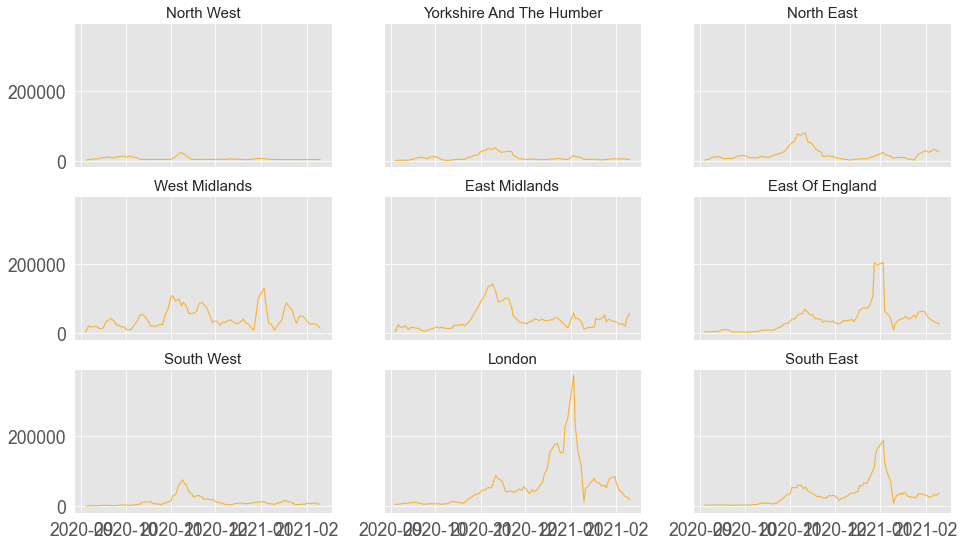

In [991]:
regions = ['North West', 'Yorkshire And The Humber', 'North East',
'West Midlands', 'East Midlands', 'East Of England',
'South West','London' , 'South East']

# Create empty dataframe
groupall=pd.DataFrame()

# Plot 7-day rolling average of RNA concentration BEFORE interpolation (as checking)
fig, axes = plt.subplots(3,3, figsize=(14,9), sharex=True, sharey=True)

for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
    group = df3[df3.region == region]
    def fn(x):
        x = x[~np.isnan(x)]
        if not len(x):
            return np.nan
        weights = group.loc[x.index, 'catch_cis_population']
        if np.sum(weights) == 0.:
            weights = np.ones(x.shape)
        return np.average(x, weights=weights)
    #     fn = lambda x: x.mean()

    grouptemp = group.groupby('date').agg(fn)
    grouptemp['region'] = regions[i]
    groupall = groupall.append(grouptemp)

    ax.plot(grouptemp.sars_cov2_gc_l_mean.rolling('7D').mean(), color='orange', lw=1.1, alpha=0.8, label=f'Wastewater data')
    ax.set_title(region, fontsize=15)

plt.show()

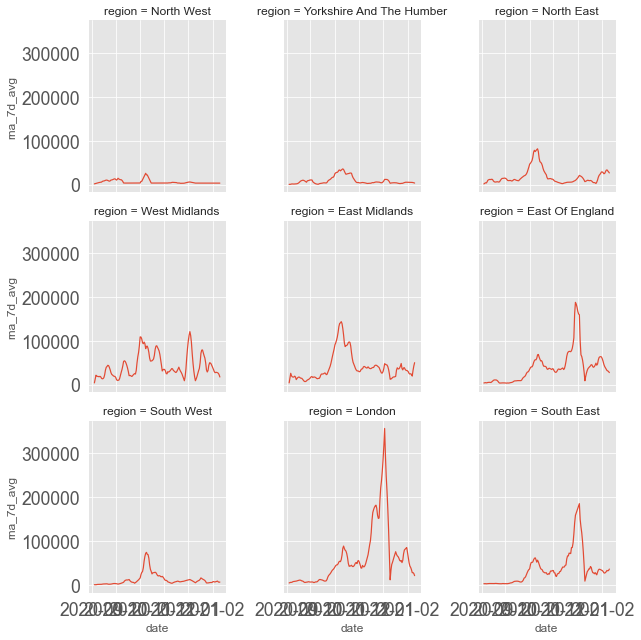

In [992]:
# Plot 7-day rolling average of RNA concentration AFTER interpolation
combined_dataset['rna_7d_avg'] = combined_dataset.groupby('region')['weighted_avg_sars_cov2'].transform(lambda x: x.rolling(7, 1).mean())

g = sns.FacetGrid(combined_dataset, col="region", col_wrap=3)
g.map(sns.lineplot, "date", "rna_7d_avg")

### Alternative method
# fig, axes = plt.subplots(3,3, figsize=(14,9), sharex=True, sharey=True)
# for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
#     group = combined_dataset[combined_dataset.region == region]
#     ax.plot(group.weighted_avg_sars_cov2.rolling(7).mean(), color='orange', lw=1.1, alpha=0.8, label=f'Wastewater data')
#     ax.set_title(region, fontsize=15)

# plt.show()

In [993]:
# check if dataframe is indexed (should be False)
# pd.Index(np.arange(0, len(combined_dataset))).equals(combined_dataset.index)

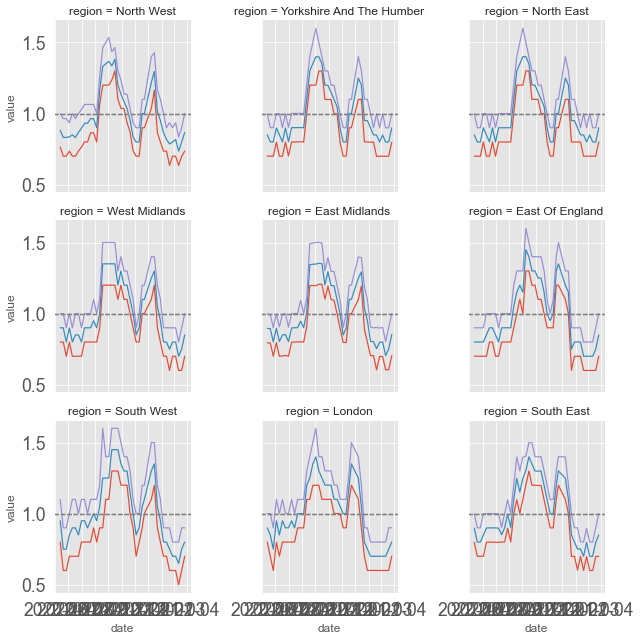

In [994]:
# Weighted Rt (Upper bound / Lower Bound / Average)
m = weighted_r.copy()
m = m.melt(id_vars=['date', 'region'])

g = sns.FacetGrid(m, col="region", col_wrap=3,
                  col_order=['North West', 'Yorkshire And The Humber', 'North East',
                             'West Midlands', 'East Midlands', 'East Of England',
                             'South West','London' , 'South East'],
                  hue='variable')
g.map(sns.lineplot, "date", "value")
g.refline(y=1)

# Export Linked Datasets

In [995]:
# Write required datasets to csv file
combined_dataset.to_csv("data/linked_data.csv")
combined_cases.to_csv("data/cleaned_cases.csv")
weighted_r.to_csv("data/weighted_r.csv")
model_dataset.to_csv('data/all_var (before interpolation).csv')

In [996]:
# Write each subset to a separate csv file
for i, outfile in zip(interpolated_subset, ["subsets/sw.csv", "subsets/se.csv",
                                            "subsets/ldn.csv","subsets/ee.csv",
                                            "subsets/em.csv", "subsets/wm.csv",
                                            "subsets/nw.csv", "subsets/ne.csv",
                                            "subsets/yh.csv"]):
    i.to_csv(outfile)

In [998]:
# Export descriptive statistics
combined_dataset.describe().to_csv("data/wrangled_summary.csv")
df.describe().to_csv("data/original_summary.csv")

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

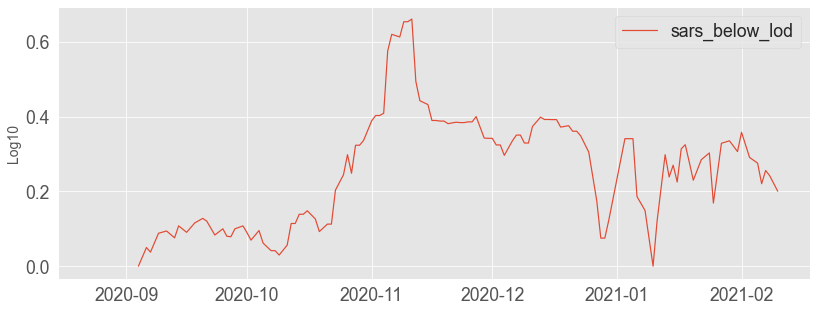

In [997]:
### Copied from UKHSA Code for checking purpose
# # Check national numbers
# import datetime
#
# for col in ['sars_cov2_gc_l_mean', 'ammonia_mg_l', 'control_gc_l_mean', 'sample_ph_pre_ansis', "sars_below_loq", 'sars_below_lod']:
#     plt.figure(figsize=(12, 5))
# plt.plot(df.groupby('date').mean().rolling('7D').mean()[col], label=col)
# plt.xlim(datetime.datetime(2020, 8, 15))
# #     plt.ylabel('SARS-CoV2 Concentration Log10(gc/L)', fontsize=13)
# plt.ylabel('Log10', fontsize=14)
# plt.legend()